# Section 1 : Environnement

In [ ]:
import numpy as np
class BattleshipGame:
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)    # 0: empty, 1: hit, 2: ship, -1: miss
        self.grid_visible = np.zeros((self.grid_size, self.grid_size), dtype=int)      # 0: empty, 1: hit, -1: miss   (for the player to see)
        self.number_of_hits = 0
        self.ships = []    # List of ships with their lengths, positions, directions, and states
        self.rdisc = 0     # reward discount
        self.initialize_ships_little()
        self.legal_actions = [] # legal (empty) cells available for moves
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                self.legal_actions.append((i,j))    # this gets updated as an action is performed

        return self.grid_visible    # return the visible board

    def initialize_ships(self):
        ship_definitions = [(2, 1), (3, 1), (4, 1)]     # (length, quantity)
        self.total_hits = 9
        for length, quantity in ship_definitions:
            for _ in range(quantity):
                self.place_ship_randomly(length)

    def initialize_ships_little(self):
        ship_definitions = [(3,1)]     # (length, quantity)
        self.total_hits = 3
        for length, quantity in ship_definitions:
            for _ in range(quantity):
                self.place_ship_randomly(length)

    def display(self):
        symbols = {0: '🌊', 2: '🚢', 1: '💥', -1: '⚪'}

        header = " " + "   ".join(str(i).rjust(3) for i in range(self.grid_size))
        print(header)

        for y in range(self.grid_size):
            row_symbols = [symbols[self.grid[y, x]] for x in range(self.grid_size)]
            row_str = str(y).ljust(3) + ' ' + '   '.join(row_symbols)
            print(row_str)

    def display_visible(self):
        symbols = {0: '🌊', 2: '🚢', 1: '💥', -1: '⚪'}

        header = " " + "   ".join(str(i).rjust(3) for i in range(self.grid_size))
        print(header)

        for y in range(self.grid_size):
            row_symbols = [symbols[self.grid_visible[y, x]] for x in range(self.grid_size)]
            row_str = str(y).ljust(3) + ' ' + '   '.join(row_symbols)
            print(row_str)

    def step(self, action):
        i , j = np.unravel_index(action, (self.grid_size,self.grid_size))

        state = self.grid_visible.copy()

        empty_cnts_pre, hit_cnts_pre, miss_cnts_pre = self.board_config(state)    # board situation before action

        reward = 0
        if (i,j) not in self.legal_actions:
            keep_rndm = True
            while keep_rndm:
                action = np.random.randint(0,self.grid_size*self.grid_size)
                i, j = np.unravel_index(action, (self.grid_size,self.grid_size))
                if (i,j) in self.legal_actions:
                    keep_rndm = False
                reward -= 1 + (1-empty_cnts_pre)/(self.grid_size*self.grid_size)    # penalize for illegal move

        self.set_state(action)   # update the board with the action

        self.set_legal_actions((i,j))

        next_state = self.grid_visible

        empty_cnts_post, hit_cnts_post, miss_cnts_post = self.board_config(next_state)      # board situation after action

        done = bool(hit_cnts_post == self.total_hits)

        if hit_cnts_post-hit_cnts_pre==1: #hit
            r_discount = 0.5**self.rdisc
            reward += 10*r_discount*hit_cnts_post     # reward for a hit

        reward = float(reward)

        # after a hit, zero the discount, also don't start discounting if first hit hasn't happened yet
        if hit_cnts_post-hit_cnts_pre==1 or hit_cnts_pre==0:
            self.rdisc = 0
        else:
            # we discount the reward for a subsequent hit the longer it takes to score it
            self.rdisc += 1


        return next_state, reward, done

    def update_ships_status(self, action):
        x, y = action
        sunk = False
        for ship in self.ships:
            if not ship['sunk']:
                positions = self.calculate_ship_positions(ship)
                if (x, y) in positions:
                    ship['hits'] += 1
                    if ship['hits'] == ship['length']:
                        ship['sunk'] = True
                        sunk = True
                        break
        return sunk

    def calculate_ship_positions(self, ship):
        x, y = ship['position']
        positions = [(x+i, y) if ship['direction'] == 'H' else (x, y+i) for i in range(ship['length'])]
        return positions

    def check_all_sunk(self):
        return all(ship['sunk'] for ship in self.ships)

    def is_action_valid(self, action):
        x, y = action
        return self.grid[y, x] >= 0

    def place_ship_randomly(self, ship_length):
        placed = False
        while not placed:
            direction = 'H' if np.random.rand() > 0.5 else 'V'
            if direction == 'H':
                x = np.random.randint(0, self.grid_size - ship_length + 1)
                y = np.random.randint(0, self.grid_size)
            else:
                x = np.random.randint(0, self.grid_size)
                y = np.random.randint(0, self.grid_size - ship_length + 1)
            if self.check_free_space(ship_length, (x, y), direction):
                self.add_ship(ship_length, (x, y), direction)
                placed = True

    def check_free_space(self, ship_length, position, direction):
        x, y = position
        if direction.upper() == 'H':
            return all(self.grid[y, x+i] == 0 for i in range(ship_length))
        else:
            return all(self.grid[y+i, x] == 0 for i in range(ship_length))

    def add_ship(self, ship_length, position, direction):
        x, y = position
        if direction == 'H':
            self.grid[y, x:x+ship_length] = 2
        else:
            self.grid[y:y+ship_length, x] = 2
        self.ships.append({'length': ship_length, 'hits': 0, 'position': position, 'direction': direction, 'sunk': False})

    def board_config(self, state):
        uni_states, uni_cnts = np.unique(state.ravel(), return_counts=True)
        empty_cnts = uni_cnts[uni_states == 0]
        hit_cnts = uni_cnts[uni_states == 1]
        miss_cnts = uni_cnts[uni_states == -1]

        if len(empty_cnts)==0:
            empty_cnts = 0
        else:
            empty_cnts = empty_cnts[0]
        if len(hit_cnts)==0:
            hit_cnts = 0
        else:
            hit_cnts = hit_cnts[0]
        if len(miss_cnts)==0:
            miss_cnts = 0
        else:
            miss_cnts = miss_cnts[0]

        return empty_cnts, hit_cnts, miss_cnts

    def get_legal_actions(self):
        return self.legal_actions

    def set_legal_actions(self, action):
        if action in self.legal_actions:
            self.legal_actions.remove(action)

    def set_state(self, action):
        i , j = np.unravel_index(action, (self.grid_size,self.grid_size))
        if self.grid[i,j]==2:
            self.grid[i,j]= 1
            self.grid_visible[i,j] = 1
        else:
            self.grid[i,j]= -1
            self.grid_visible[i,j] = -1

    def play_episode(self, agent):
        self.reset()
        done = False
        reward = 0
        action = 0
        while not done:
            action = agent.choose_action(action, reward)
            self.number_of_hits += 1
            grid, reward, done = self.step(action)
        print(f"Number of hits: {self.number_of_hits}")
        return self.number_of_hits

# Section 2 : Simple Agents

In [ ]:
# Agent that chooses random actions

class random_agent():
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
    def choose_action(self, state, hit):
        return np.random.randint(0, self.grid_size**2)

In [ ]:
# Agent that searches for ships and then hunts them until they are sunk and then searches again

class search_and_hunt_agent():
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
        self.is_hunting = False
        self.ship_hunted = []
        self.searched = []

    def choose_action(self, state, reward):
        if not self.is_hunting and reward >0:
            self.is_hunting = True
        if self.is_hunting:
            return self.hunt_ship(state, reward)
        else:
            return self.search_ship(state)

    def search_ship(self, state):
        action = np.random.randint(0, self.grid_size**2)
        while action in self.searched:
            action = np.random.randint(0, self.grid_size**2)
        self.searched.append(action)
        return action

    def hunt_ship(self, state, reward):
        if reward >0:
            self.ship_hunted.append(state)
        for state in self.ship_hunted:
            x, y = state % self.grid_size, state // self.grid_size
            if x > 0 and (state-1) not in self.searched:
                self.searched.append(state-1)
                return state-1
            elif x < self.grid_size-1 and (state+1) not in self.searched:
                self.searched.append(state+1)
                return state+1
            elif y > 0 and (state-self.grid_size) not in self.searched:
                self.searched.append(state-self.grid_size)
                return state-self.grid_size
            elif y < self.grid_size-1 and (state+self.grid_size) not in self.searched:
                self.searched.append(state+self.grid_size)
                return state+self.grid_size
        self.is_hunting = False
        return self.search_ship(state)

In [ ]:
env = BattleshipGame(7)
coup = 0
for i in range(1000):
    agent = search_and_hunt_agent(7)
    coup += env.play_episode(agent)

print(coup/1000)

Number of hits: 15
Number of hits: 14
Number of hits: 30
Number of hits: 19
Number of hits: 22
Number of hits: 24
Number of hits: 4
Number of hits: 11
Number of hits: 39
Number of hits: 6
Number of hits: 31
Number of hits: 12
Number of hits: 23
Number of hits: 9
Number of hits: 21
Number of hits: 28
Number of hits: 34
Number of hits: 12
Number of hits: 10
Number of hits: 22
Number of hits: 30
Number of hits: 8
Number of hits: 21
Number of hits: 14
Number of hits: 23
Number of hits: 26
Number of hits: 18
Number of hits: 9
Number of hits: 18
Number of hits: 17
Number of hits: 20
Number of hits: 7
Number of hits: 27
Number of hits: 20
Number of hits: 15
Number of hits: 11
Number of hits: 47
Number of hits: 14
Number of hits: 31
Number of hits: 12
Number of hits: 39
Number of hits: 11
Number of hits: 21
Number of hits: 14
Number of hits: 22
Number of hits: 5
Number of hits: 17
Number of hits: 27
Number of hits: 18
Number of hits: 16
Number of hits: 26
Number of hits: 7
Number of hits: 16
N

# Section 3 : DeepQLearning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class Linear_t(nn.Module):
    def __init__(self, input_dim, n_action):
        super(Linear_t, self).__init__()
        self.fc = nn.Linear(input_dim, n_action)

    def forward(self, x):
        return self.fc(x)

In [ ]:
class MLP_t(nn.Module):
    def __init__(self, input_dim, n_action):
        super(MLP_t, self).__init__()
        self.fc = nn.Linear(input_dim, 124)
        self.fc2 = nn.Linear(124, n_action)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc(x)))

In [ ]:
class EpsilonGreedy:
    """
    An Epsilon-Greedy policy.

    Attributes
    ----------
    epsilon : float
        The initial probability of choosing a random action.
    epsilon_min : float
        The minimum probability of choosing a random action.
    epsilon_decay : float
        The decay rate for the epsilon value after each action.
    env : gym.Env
        The environment in which the agent is acting.
    q_network : torch.nn.Module
        The Q-Network used to estimate action values.

    Methods
    -------
    __call__(state: np.ndarray) -> np.int64
        Select an action for the given state using the epsilon-greedy policy.
    decay_epsilon()
        Decay the epsilon value after each action.
    """

    def __init__(self,
                 epsilon_start: float,
                 epsilon_min: float,
                 epsilon_decay:float,
                 env: BattleshipGame,
                 q_network: torch.nn.Module):
        """
        Initialize a new instance of EpsilonGreedy.

        Parameters
        ----------
        epsilon_start : float
            The initial probability of choosing a random action.
        epsilon_min : float
            The minimum probability of choosing a random action.
        epsilon_decay : float
            The decay rate for the epsilon value after each episode.
        env : gym.Env
            The environment in which the agent is acting.
        q_network : torch.nn.Module
            The Q-Network used to estimate action values.
        """
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:
        """
        Select an action for the given state using the epsilon-greedy policy.

        If a randomly chosen number is less than epsilon, a random action is chosen.
        Otherwise, the action with the highest estimated action value is chosen.

        Parameters
        ----------
        state : np.ndarray
            The current state of the environment.

        Returns
        -------
        np.int64
            The chosen action.
        """

        if np.random.uniform() <= self.epsilon:
            return np.random.randint(0,grid_size*grid_size)
        else:
            state_tensor = torch.from_numpy(state.astype(np.float32)).flatten()
            pred_values = self.q_network(state_tensor)
            return np.argmax(pred_values.detach().numpy())

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [ ]:
num_episodes = 50000

grid_size=5
gamma = 0.95
learning_rate=0.001
momentum=0.9
epsilon=1.0
epsilon_min=0.01
epsilon_decay=(epsilon_min/epsilon)**(1/(0.5*num_episodes))
episode_step = 0.005

env = BattleshipGame(grid_size=grid_size)
model = MLP_t(grid_size*grid_size, grid_size*grid_size)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
loss_fn = nn.MSELoss()
losses = []
epsilon_greedy = EpsilonGreedy(epsilon_start=epsilon, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, env=env, q_network=model)
reward_plot = []
epsilon_plot = []
losses_plot = []
counter_plot = []

t1 = 0

for t in range(num_episodes):

    obs = env.reset()
    if (t) % (episode_step*num_episodes) == 0:
        print('>>>>>>>>>>>>>>>>>>>Episode', t)
        if len(counter_plot)>0:
            print('Avg moves: ', np.mean(np.array(counter_plot).reshape(-1, int(episode_step*num_episodes))[t1]))
            print('Avg loss: ', np.mean(np.array(losses_plot).reshape(-1, int(episode_step*num_episodes))[t1]))
            t1 += 1

    if t==0:
        epsilon_plot = [0 for i in range(num_episodes)]
        counter_plot = [0 for i in range(num_episodes)]
        reward_plot = [0 for i in range(num_episodes)]
        losses_plot = [0 for i in range(num_episodes)]

    done  = False

    while not done:
        state = env.grid_visible.copy()
        action = epsilon_greedy(state)

        next_state, reward, done = env.step(action)

        state_tensor = torch.from_numpy(state.astype(np.float32)).flatten()
        action_tensor = torch.tensor(action)
        reward_tensor = torch.tensor(reward, dtype=torch.float32)
        next_state_tensor = torch.from_numpy(next_state.astype(np.float32)).flatten()

        with torch.no_grad():
            target = reward_tensor.clone()
            if not done:
                pred_values_next = model(next_state_tensor)
                target += gamma * torch.max(pred_values_next)

        pred_values = model(state_tensor)
        pred_values[action_tensor] = target
        optimizer.zero_grad()
        output = model(state_tensor)
        loss = loss_fn(output, pred_values)
        loss.backward()
        optimizer.step()

        losses_plot[t] += loss.item()

        counter_plot[t] += 1
        reward_plot[t] += reward
        epsilon_plot[t] = epsilon_greedy.epsilon

        if done:
            break

    epsilon_greedy.decay_epsilon()

>>>>>>>>>>>>>>>>>>>Episode 0
>>>>>>>>>>>>>>>>>>>Episode 250
Avg moves:  19.504
Avg loss:  19.736492963695945
>>>>>>>>>>>>>>>>>>>Episode 500
Avg moves:  18.748
Avg loss:  20.042866870552157
>>>>>>>>>>>>>>>>>>>Episode 750
Avg moves:  19.136
Avg loss:  23.55765231092625
>>>>>>>>>>>>>>>>>>>Episode 1000
Avg moves:  19.084
Avg loss:  21.014427912846852
>>>>>>>>>>>>>>>>>>>Episode 1250
Avg moves:  19.236
Avg loss:  19.820669182455386
>>>>>>>>>>>>>>>>>>>Episode 1500
Avg moves:  19.412
Avg loss:  27.784993110165946
>>>>>>>>>>>>>>>>>>>Episode 1750
Avg moves:  18.672
Avg loss:  22.94448220540798
>>>>>>>>>>>>>>>>>>>Episode 2000
Avg moves:  18.64
Avg loss:  23.834932550484876
>>>>>>>>>>>>>>>>>>>Episode 2250
Avg moves:  18.824
Avg loss:  25.150858283751347
>>>>>>>>>>>>>>>>>>>Episode 2500
Avg moves:  19.384
Avg loss:  23.833761368896987
>>>>>>>>>>>>>>>>>>>Episode 2750
Avg moves:  19.38
Avg loss:  28.013305126108044
>>>>>>>>>>>>>>>>>>>Episode 3000
Avg moves:  18.384
Avg loss:  20.527355783894365
>>>>>>

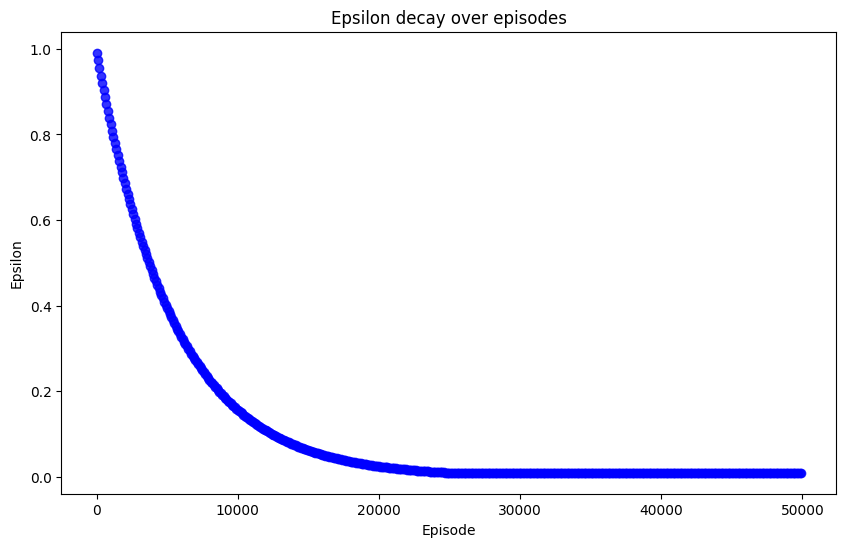

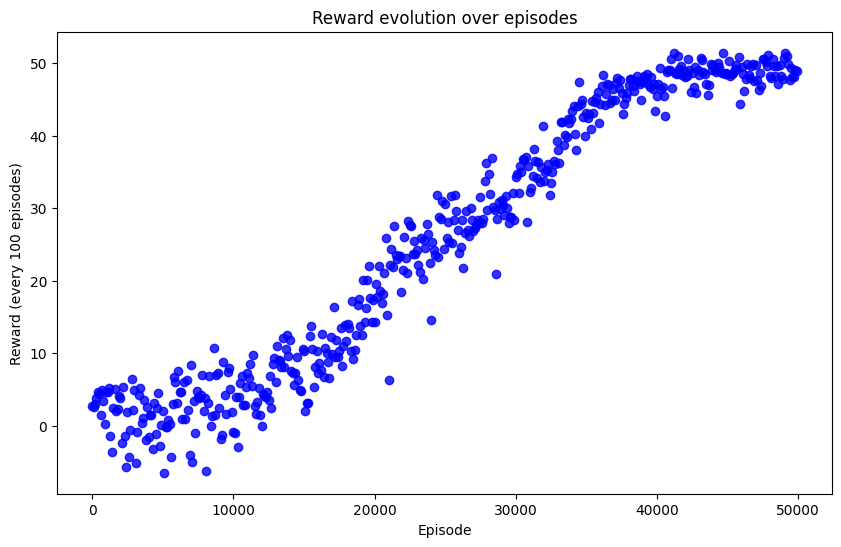

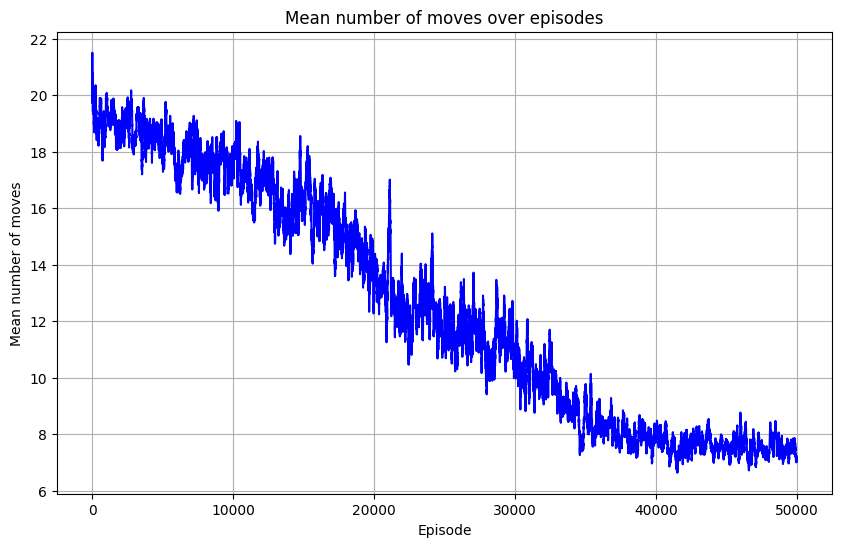

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_episode_step = 100

epsilon_plot_np = np.array(epsilon_plot)
losses_plot_np = np.array(losses_plot)
reward_plot_np = np.array(reward_plot)

episode_range = np.arange(0, num_episodes, num_episode_step)

plt.figure(figsize=(10, 6))
sns.regplot(x=episode_range, y=np.mean(epsilon_plot_np.reshape(-1, num_episode_step), axis=1), color="b", line_kws={'color':'green'}, fit_reg=False)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon decay over episodes')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x=episode_range, y=np.mean(reward_plot_np.reshape(-1, num_episode_step), axis=1), color="b", lowess=True, line_kws={'color':'green'}, fit_reg=False)
plt.xlabel('Episode')
plt.ylabel('Reward (every {} episodes)'.format(num_episode_step))
plt.title('Reward evolution over episodes')
plt.show()

moving_avg_counter = [np.mean(counter_plot[max(0, i - num_episode_step):i + 1]) for i in range(len(counter_plot))]
plt.figure(figsize=(10, 6))
plt.plot(range(len(moving_avg_counter)), moving_avg_counter, color='b', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Mean number of moves')
plt.title('Mean number of moves over episodes')
plt.grid(True)
plt.show()


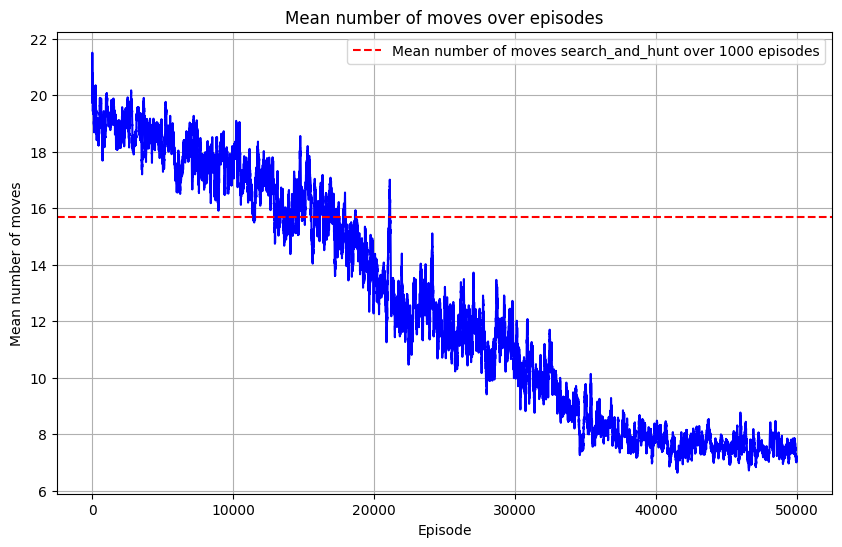

In [ ]:
avg_search_and_hunt = 15.7

moving_avg_counter = [np.mean(counter_plot[max(0, i - num_episode_step):i + 1]) for i in range(len(counter_plot))]
plt.figure(figsize=(10, 6))
plt.plot(range(len(moving_avg_counter)), moving_avg_counter, color='b', linestyle='-')
plt.axhline(y=avg_search_and_hunt, color='r', linestyle='--', label='Mean number of moves search_and_hunt over 1000 episodes')
plt.xlabel('Episode')
plt.ylabel('Mean number of moves')
plt.title('Mean number of moves over episodes')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#test

num_episodes_test = 10000
grid_size=5
env = BattleshipGame(grid_size=grid_size)

mean_hits = 0
for t in range(num_episodes_test):
    obs = env.reset()
    done  = False
    number_of_hits = 0

    while not done:
        state = env.grid_visible.copy()

        state_tensor = torch.from_numpy(state.astype(np.float32)).flatten()
        pred_values = model(state_tensor)
        action = np.nanargmax(pred_values.detach().numpy())

        next_state, reward, done = env.step(action)

        number_of_hits += 1
        if done:
            break

    mean_hits += number_of_hits

print(mean_hits/num_episodes_test)

7.481
